In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
LCLid             1222670 non-null object
tstp              1222670 non-null datetime64[ns]
energy(kWh/hh)    1222620 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39292


39225

In [8]:
# Also find bank holidays
df_hols = pd.read_csv('./data/smart-meters-in-london/uk_bank_holidays.csv', parse_dates=[0])
holidays = set(df_hols['Bank holidays'].dt.round('D'))

df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

In [9]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0
df['minute'] = time.dt.minute / 24.0
df['dayofweek'] = time.dt.dayofweek / 7.0

In [10]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.449333,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.021976,0.529373,0.050786,0.495566,0.479369,0.624984,0.428291
std,0.218992,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.146606,0.306145,0.028288,0.307568,0.288379,0.625008,0.285822
min,0.023000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.000000,0.083333,0.003226,0.019231,0.000000,0.000000,0.000000
25%,0.293000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.000000,0.250000,0.025806,0.211538,0.250000,0.000000,0.142857
50%,0.436444,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.000000,0.500000,0.051613,0.480769,0.500000,0.000000,0.428571
75%,0.583932,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.000000,0.833333,0.074194,0.769231,0.750000,1.250000,0.714286
max,1.981000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,1.000000,0.100000,1.000000,0.958333,1.250000,0.857143


In [11]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

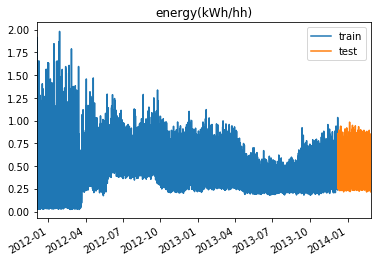

In [12]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

In [13]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy, legend=False):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2, label='true')
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6, label='input data')
    ylims=plt.ylim()
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2, label='predicted')
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True,
    label='uncertainty')

    # Make the plot pretty
    plt.grid('off')
    plt.ylim(*ylims)
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid(b=None)
    if legend:
        plt.legend()
    ax = plt.gca()
    plt.show()

In [14]:
def plot_from_loader(loader, i=0, undo_log=use_logy, title='', plot=True, legend=False):
    data = loader.collate_fn([loader.dataset[i]])
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        if plot:
            plt.title(title+f" loss={loss_test: 2.2g}")
            plot_functions(target_x.detach().cpu().numpy(),
                            target_y.detach().cpu().numpy(),
                            context_x.detach().cpu().numpy(),
                            context_y.detach().cpu().numpy(),
                            y_pred.detach().cpu().numpy(),
                            y_std.detach().cpu().numpy(), undo_log=undo_log, legend=legend)
    return loss_test

# Dataloaders

In [15]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [16]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [17]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 78, 16]), torch.Size([32, 78, 1]))

In [38]:
from src.models.model import LatentModel
model = LatentModel(
    x_dim=x.shape[-1], 
    y_dim=y.shape[-1], 
    hidden_dim=128,
    latent_dim=128,
    dropout=0.5,
    attention_dropout=0,
    num_heads=8,
    n_latent_encoder_layers=6,
    n_det_encoder_layers=6,
    n_decoder_layers=6,
    latent_enc_self_attn_type="multihead", 
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead",
    use_lvar=True,
    use_deterministic_path=False
).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [39]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss = model(context_x, context_y, target_x, target_y)

                                                   Kernel Shape       Output Shape   Params Mult-Adds
Layer                                                                                                
0__latent_encoder._input_layer.Linear_linear          [17, 128]      [32, 97, 128]   2.304k    2.176k
1__latent_encoder._input_layer.ReLU_act                       -      [32, 97, 128]        -         -
2__latent_encoder._input_layer.BatchNorm2d_norm           [128]   [32, 128, 97, 1]    256.0     128.0
3__latent_encoder._input_layer.Dropout2d_dropout              -   [32, 128, 97, 1]        -         -
4__latent_encoder._encoder.0.Linear_linear           [128, 128]      [32, 97, 128]  16.512k   16.384k
5__latent_encoder._encoder.0.ReLU_act                         -      [32, 97, 128]        -         -
6__latent_encoder._encoder.0.BatchNorm2d_norm             [128]   [32, 128, 97, 1]    256.0     128.0
7__latent_encoder._encoder.0.Dropout2d_dropout                -   [32, 128, 97, 1]

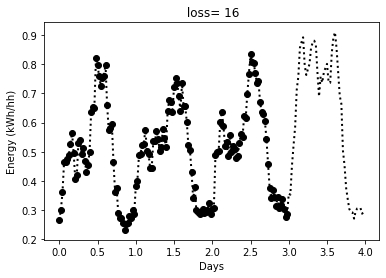

tensor(16.3635, device='cuda:0')

In [40]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, i=vis_i)

0, i=0, loss: 423.5, test: 16.19, grad_norm:  1.4e+05, std:  0.14
0, i=100, loss: 9.211, test: 2.99, grad_norm:  1.7e+02, std:  53
0, i=200, loss: 3.039, test: 1.787, grad_norm:  8.2, std:  5.9e+08
0, i=300, loss: 1.019, test: 0.1429, grad_norm:  78, std:  54
0, i=400, loss: 0.4076, test: -0.3007, grad_norm:  9.5, std:  5.3e+06
0, i=500, loss: -0.1462, test: -0.645, grad_norm:  4.6, std:  1.8
0, i=600, loss: -0.4582, test: -0.7722, grad_norm:  3.5, std:  2.2e+02
0, i=700, loss: -0.2184, test: -0.8552, grad_norm:  6.2, std:  7.3e+04
0, i=800, loss: -0.4374, test: -0.9992, grad_norm:  4.5, std:  1.4e+10
0, i=900, loss: -0.5655, test: -1.042, grad_norm:  4.2, std:  1.3e+07
0, i=1000, loss: -0.7266, test: -1.067, grad_norm:  2.8, std:  3


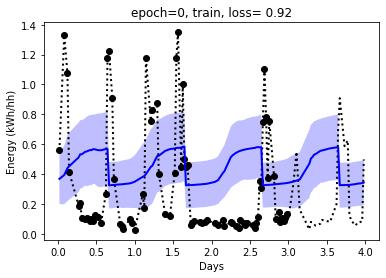

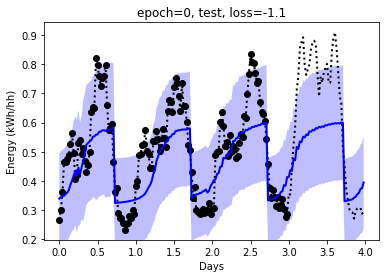

epoch: 0, loss: 0.434, loss_test:-1.055, kl=-0.03, grad_norm:  17


1, i=0, loss: -0.6728, test: -1.046, grad_norm:  4.3, std:  0.5
1, i=100, loss: -0.6263, test: -1.112, grad_norm:  4, std:  1.7
1, i=200, loss: 32.87, test: -0.9969, grad_norm:  5.2e+04, std:  58
1, i=300, loss: -0.6906, test: -1.028, grad_norm:  3.5, std:  6.9e+07
1, i=400, loss: -0.6969, test: -1.102, grad_norm:  3.9, std:  0.46
1, i=500, loss: -0.673, test: -1.123, grad_norm:  3.9, std:  0.71
1, i=600, loss: -0.3745, test: -1.072, grad_norm:  2.5e+02, std:  0.2
1, i=700, loss: -0.9103, test: -1.11, grad_norm:  3.4, std:  2.5e+02
1, i=800, loss: -0.6906, test: -1.108, grad_norm:  3.8, std:  38
1, i=900, loss: -0.6967, test: -1.054, grad_norm:  3.2, std:  1.5e+02
1, i=1000, loss: -0.8105, test: -1.132, grad_norm:  2.1, std:  0.36


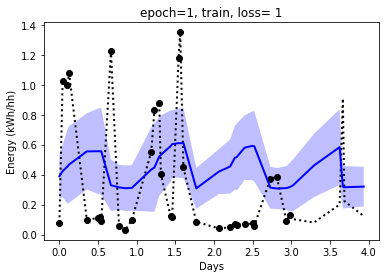

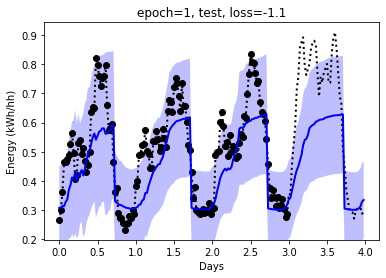

epoch: 1, loss: -1.134, loss_test:-1.087, kl=-0.66, grad_norm:  7.6


2, i=0, loss: -0.788, test: -1.073, grad_norm:  3.6, std:  0.2
2, i=100, loss: -0.9222, test: -1.13, grad_norm:  3, std:  5.3e+03
2, i=200, loss: -0.939, test: -1.105, grad_norm:  3.7, std:  0.22
2, i=300, loss: -0.6614, test: -1.041, grad_norm:  2.8, std:  8.1e+03
2, i=400, loss: -0.6256, test: -1.086, grad_norm:  4.7, std:  15
2, i=500, loss: -0.9574, test: -1.104, grad_norm:  2.2, std:  4.8e+06
2, i=600, loss: -0.7833, test: -1.095, grad_norm:  3, std:  1.9e+02
2, i=700, loss: -0.7178, test: -1.123, grad_norm:  2.7, std:  1.2
2, i=800, loss: -0.7203, test: -1.078, grad_norm:  4, std:  7.4e+02
2, i=900, loss: -0.8032, test: -1.121, grad_norm:  2.4, std:  7e+02
2, i=1000, loss: -0.7038, test: -0.9722, grad_norm:  2.4, std:  0.85


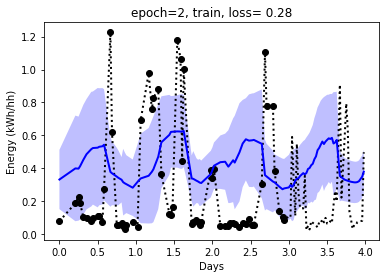

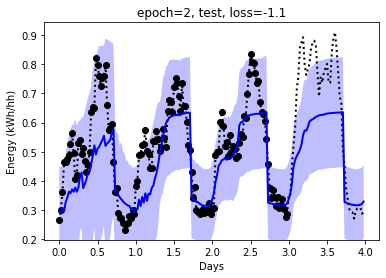

epoch: 2, loss: -0.5611, loss_test:-1.099, kl=-0.55, grad_norm:  6.8


3, i=0, loss: -0.7654, test: -1.097, grad_norm:  3.2, std:  1.7e+03
3, i=100, loss: -0.8941, test: -1.103, grad_norm:  3.2, std:  4.4e+08
3, i=200, loss: -0.8063, test: -1.106, grad_norm:  3, std:  2.9e+04
3, i=300, loss: -0.8001, test: -1.045, grad_norm:  2.8, std:  1.4e+02
3, i=400, loss: -0.9903, test: -1.032, grad_norm:  2.8, std:  8.4e+02
3, i=500, loss: -0.8958, test: -1.026, grad_norm:  3.6, std:  0.19
3, i=600, loss: -0.8603, test: -1.067, grad_norm:  2.7, std:  0.85
3, i=700, loss: -0.5588, test: -1.113, grad_norm:  3.6, std:  0.2
3, i=800, loss: -0.643, test: -1.022, grad_norm:  3.3, std:  0.19
3, i=900, loss: -0.8751, test: -1.079, grad_norm:  3.1, std:  1.3e+02
3, i=1000, loss: -0.9247, test: -1.032, grad_norm:  2.3, std:  6.7


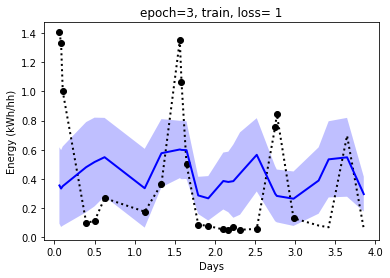

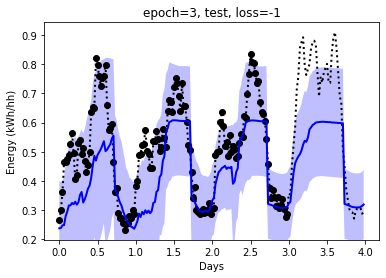

epoch: 3, loss: -0.9197, loss_test:-1.015, kl=-0.48, grad_norm:  4.6


4, i=0, loss: -0.793, test: -1.031, grad_norm:  2.6, std:  7
4, i=100, loss: -0.745, test: -1.047, grad_norm:  3, std:  3.5e+03
4, i=200, loss: -0.7963, test: -1.02, grad_norm:  2.6, std:  56
4, i=300, loss: -0.8162, test: -0.9859, grad_norm:  2.5, std:  2e+07
4, i=400, loss: -0.746, test: -1.096, grad_norm:  2.7, std:  2e+03
4, i=500, loss: -0.9556, test: -1.07, grad_norm:  1.7, std:  1.4e+10
4, i=600, loss: -1.014, test: -1.058, grad_norm:  2.1, std:  58
4, i=700, loss: -0.7754, test: -1.107, grad_norm:  2.3, std:  1.4e+03
4, i=800, loss: -0.8984, test: -1.006, grad_norm:  2.7, std:  0.26
4, i=900, loss: -0.9804, test: -0.9959, grad_norm:  1.9, std:  0.7
4, i=1000, loss: -0.9105, test: -1.076, grad_norm:  2.5, std:  2.7


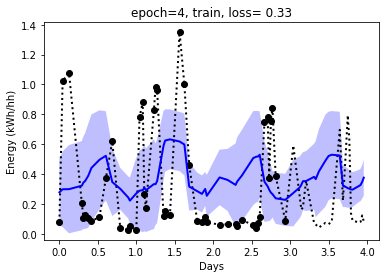

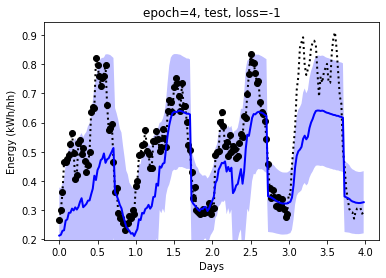

epoch: 4, loss: -0.7484, loss_test:-1.01, kl=-0.26, grad_norm:  4


5, i=0, loss: -0.6655, test: -1.018, grad_norm:  2.4, std:  3.1e+02
5, i=100, loss: -0.6476, test: -0.9592, grad_norm:  2.9, std:  2.5e+12
5, i=200, loss: -0.8652, test: -1.061, grad_norm:  3.3, std:  9e+07
5, i=300, loss: -0.8798, test: -1.031, grad_norm:  3.6, std:  0.2
5, i=400, loss: -0.9041, test: -1.074, grad_norm:  2.1, std:  1.5e+02
5, i=500, loss: -1.07, test: -0.9239, grad_norm:  2.7, std:  1.4e+09
5, i=600, loss: -0.7434, test: -0.7901, grad_norm:  2.3, std:  4.4e+11
5, i=700, loss: -0.6708, test: -0.9493, grad_norm:  16, std:  0.21
5, i=800, loss: -0.7921, test: -0.8734, grad_norm:  3.1, std:  1.9e+05
5, i=900, loss: -0.823, test: -0.9438, grad_norm:  2.7, std:  0.19
5, i=1000, loss: -0.7646, test: -0.9634, grad_norm:  2.6, std:  4.4e+02


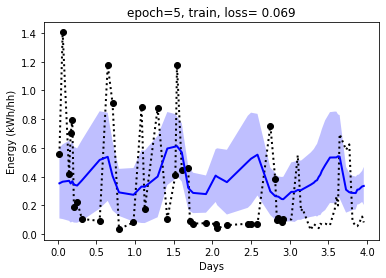

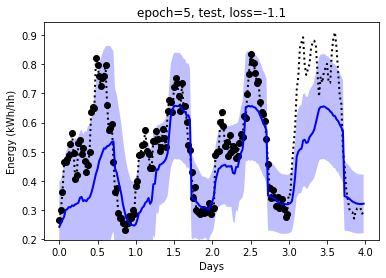

epoch: 5, loss: -0.7953, loss_test:-1.073, kl=-0.52, grad_norm:  6.9


6, i=0, loss: -0.8951, test: -1.067, grad_norm:  2.4, std:  0.74
6, i=100, loss: -0.7344, test: -0.9838, grad_norm:  3.8, std:  5.1e+05
6, i=200, loss: -0.845, test: -0.8102, grad_norm:  29, std:  0.17
6, i=300, loss: -0.9022, test: -0.9239, grad_norm:  2.2, std:  7.4e+03
6, i=400, loss: -0.9128, test: -1.018, grad_norm:  3, std:  2.4e+03
6, i=500, loss: -0.979, test: -0.8334, grad_norm:  1.7, std:  1.1e+09
6, i=600, loss: -0.6122, test: -0.9648, grad_norm:  3.1, std:  1.3e+04
6, i=700, loss: -0.9041, test: -0.9594, grad_norm:  2.1, std:  7.3
6, i=800, loss: -0.851, test: -0.9391, grad_norm:  3.1, std:  0.18
6, i=900, loss: -0.8954, test: -0.8346, grad_norm:  3.8, std:  1.4e+03
6, i=1000, loss: -0.9754, test: -0.9633, grad_norm:  2.9, std:  17


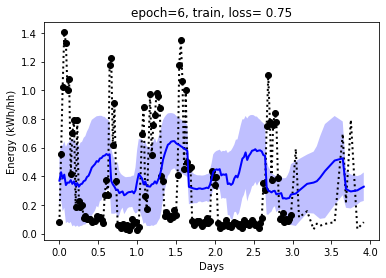

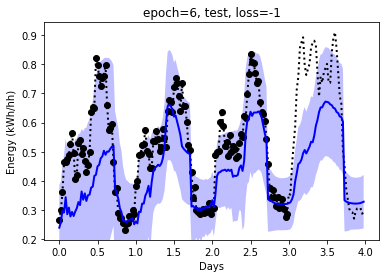

epoch: 6, loss: -0.378, loss_test:-1.038, kl=-0.52, grad_norm:  18


7, i=0, loss: -0.8484, test: -1.006, grad_norm:  3, std:  0.72
7, i=100, loss: -0.7606, test: -0.9229, grad_norm:  1.8, std:  77
7, i=200, loss: -0.8147, test: -1.001, grad_norm:  4.8, std:  0.2
7, i=300, loss: -0.8923, test: -0.8581, grad_norm:  2.2, std:  13
7, i=400, loss: -1.018, test: -0.9168, grad_norm:  2.3, std:  3e+02
7, i=500, loss: -0.9841, test: -0.9019, grad_norm:  2.4, std:  7.8e+04
7, i=600, loss: -0.7799, test: -0.9008, grad_norm:  3.4, std:  8e+02
7, i=700, loss: -0.7708, test: -0.8569, grad_norm:  2.4, std:  0.68
7, i=800, loss: -0.8727, test: -0.8574, grad_norm:  2.5, std:  0.41
7, i=900, loss: -1.03, test: -1.037, grad_norm:  2.3, std:  4.5e+03
7, i=1000, loss: -0.765, test: -0.8925, grad_norm:  2.7, std:  1.4e+12


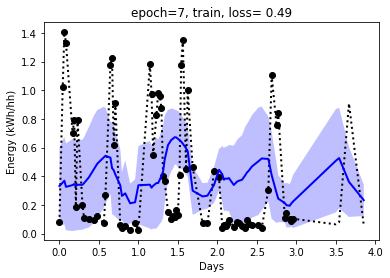

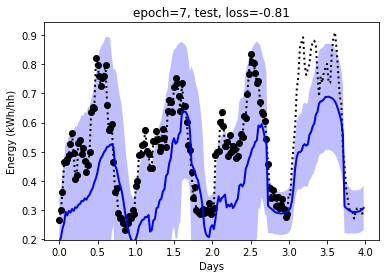

epoch: 7, loss: -0.2471, loss_test:-0.8111, kl=-0.36, grad_norm:  6.6


8, i=0, loss: -1.09, test: -0.8283, grad_norm:  2.6, std:  47
8, i=100, loss: -0.9993, test: -0.8633, grad_norm:  1.5, std:  0.53
8, i=200, loss: -0.896, test: -0.7445, grad_norm:  2.2, std:  0.21
8, i=300, loss: -0.7965, test: -0.928, grad_norm:  1.8, std:  4.8e+04
8, i=400, loss: -1.076, test: -0.675, grad_norm:  2.1, std:  9.5e+02
8, i=500, loss: -0.9079, test: -0.8967, grad_norm:  2.1, std:  73
8, i=600, loss: -0.9327, test: -0.8968, grad_norm:  2.5, std:  0.17
8, i=700, loss: -0.9972, test: -0.8212, grad_norm:  2.7, std:  2.6e+04
8, i=800, loss: -0.9771, test: -0.832, grad_norm:  2.1, std:  1.1e+03
8, i=900, loss: -1.023, test: -1.02, grad_norm:  3.4, std:  1.8e+08
8, i=1000, loss: -0.9249, test: -0.851, grad_norm:  3.9, std:  1.2e+05


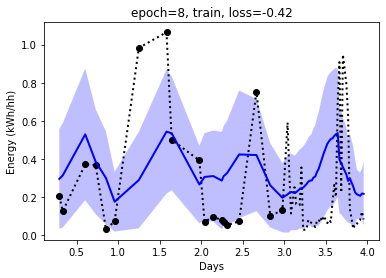

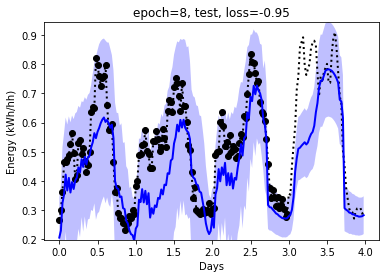

epoch: 8, loss: -1.218, loss_test:-0.9498, kl=-0.56, grad_norm:  5.7


9, i=0, loss: -0.9616, test: -1.011, grad_norm:  4.1, std:  0.15
9, i=100, loss: -1.163, test: -1.127, grad_norm:  2.2, std:  41
9, i=200, loss: -1.273, test: -1.228, grad_norm:  2, std:  5.8e+04
9, i=300, loss: -1.19, test: -1.261, grad_norm:  1.8, std:  1.2e+02
9, i=400, loss: -0.8075, test: -1.425, grad_norm:  4.7, std:  5.7e+04
9, i=500, loss: -1.377, test: -1.179, grad_norm:  6, std:  0.25
9, i=600, loss: -1.224, test: -1.435, grad_norm:  1.9, std:  1.4e+04
9, i=700, loss: -0.7722, test: -1.443, grad_norm:  7.2, std:  52
9, i=800, loss: -1.131, test: -1.397, grad_norm:  3.1, std:  25
9, i=900, loss: -1.243, test: -1.348, grad_norm:  3.3, std:  0.47
9, i=1000, loss: -1.362, test: -1.43, grad_norm:  2, std:  0.34


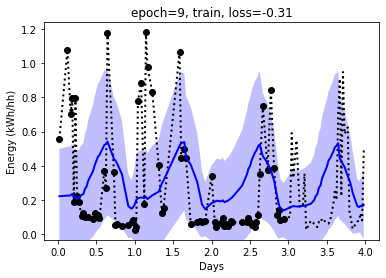

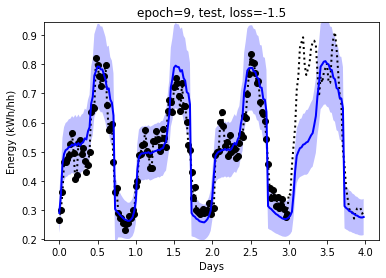

epoch: 9, loss: -0.5498, loss_test:-1.456, kl=-0.42, grad_norm:  50


10, i=0, loss: -1.284, test: -1.454, grad_norm:  2.8, std:  8.7e+03
10, i=100, loss: -1.181, test: -1.432, grad_norm:  3.3, std:  0.22
10, i=200, loss: -0.9719, test: -1.385, grad_norm:  5.6, std:  3.2
10, i=300, loss: -1.265, test: -1.451, grad_norm:  2.6, std:  81
10, i=400, loss: -1.213, test: -1.517, grad_norm:  4.2, std:  0.16
10, i=500, loss: -1.177, test: -1.446, grad_norm:  2.4, std:  6.4e+02
10, i=600, loss: -1.198, test: -1.438, grad_norm:  3.4, std:  3.3e+03
10, i=700, loss: -1.399, test: -1.427, grad_norm:  2.9, std:  0.18
10, i=800, loss: -1.353, test: -1.473, grad_norm:  2.2, std:  4.9e+02
10, i=900, loss: -1.207, test: -1.48, grad_norm:  4.8, std:  2.4e+03
10, i=1000, loss: -1.368, test: -1.413, grad_norm:  3.7, std:  0.37


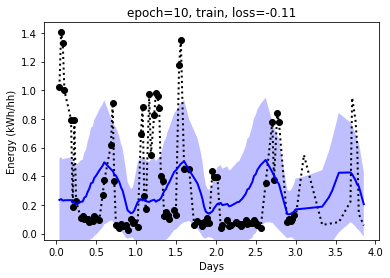

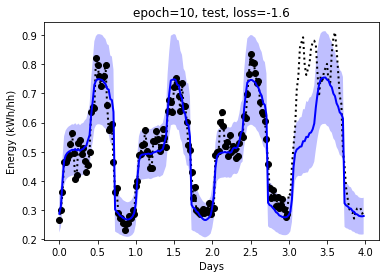

epoch: 10, loss: -1.487, loss_test:-1.577, kl=-0.75, grad_norm:  9.4


11, i=0, loss: -1.131, test: -1.553, grad_norm:  10, std:  0.2
11, i=100, loss: -1.385, test: -1.56, grad_norm:  2.4, std:  1.4
11, i=200, loss: -1.314, test: -1.51, grad_norm:  4.4, std:  0.14
11, i=300, loss: -1.237, test: -1.506, grad_norm:  1.9, std:  3.3e+03
11, i=400, loss: -1.155, test: -1.524, grad_norm:  4.3, std:  1.1
11, i=500, loss: -1.307, test: -1.622, grad_norm:  1.9, std:  2
11, i=600, loss: -1.204, test: -1.487, grad_norm:  4.8, std:  0.42
11, i=700, loss: -1.229, test: -1.504, grad_norm:  2.4, std:  37
11, i=800, loss: -1.272, test: -1.498, grad_norm:  6.3, std:  8e+02
11, i=900, loss: -1.207, test: -1.593, grad_norm:  3, std:  1.5e+03
11, i=1000, loss: -1.419, test: -1.583, grad_norm:  2.1, std:  3.1


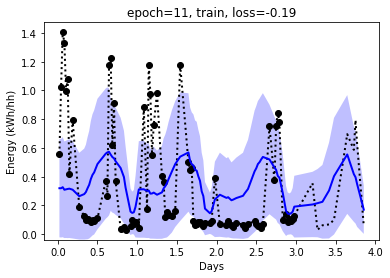

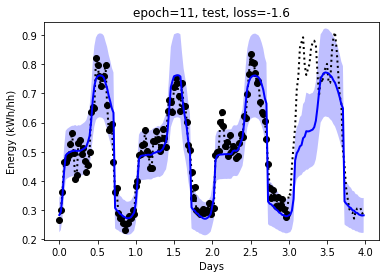

epoch: 11, loss: -1.067, loss_test:-1.584, kl=-0.6, grad_norm:  9.3


12, i=0, loss: -1.186, test: -1.573, grad_norm:  7.3, std:  0.2
12, i=100, loss: -1.353, test: -1.628, grad_norm:  2.4, std:  4.2e+02
12, i=200, loss: -1.22, test: -1.439, grad_norm:  11, std:  0.14
12, i=300, loss: -1.253, test: -1.583, grad_norm:  2.8, std:  0.21
12, i=400, loss: -1.275, test: -1.457, grad_norm:  2.2, std:  0.13
12, i=500, loss: -1.153, test: -1.627, grad_norm:  4, std:  45
12, i=600, loss: -1.454, test: -1.618, grad_norm:  3.6, std:  0.13
12, i=700, loss: -1.337, test: -1.614, grad_norm:  2, std:  0.13
12, i=800, loss: -1.065, test: -1.635, grad_norm:  5.5, std:  0.14
12, i=900, loss: -1.264, test: -1.653, grad_norm:  2.7, std:  0.3
12, i=1000, loss: -1.254, test: -1.429, grad_norm:  3.4, std:  0.13


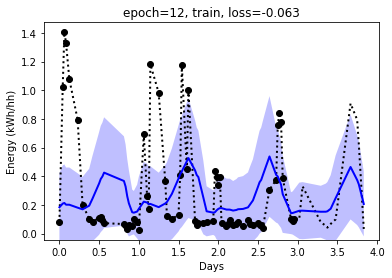

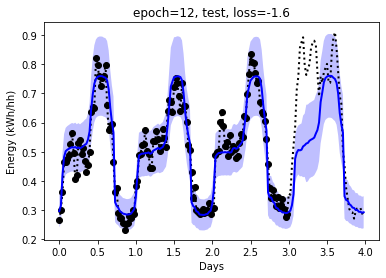

epoch: 12, loss: -1.447, loss_test:-1.599, kl=-0.73, grad_norm:  7.7


13, i=0, loss: -1.252, test: -1.598, grad_norm:  6.3, std:  0.63
13, i=100, loss: -1.347, test: -1.671, grad_norm:  6.7, std:  0.16
13, i=200, loss: -1.077, test: -1.702, grad_norm:  6.4, std:  61
13, i=300, loss: -1.474, test: -1.644, grad_norm:  3, std:  0.24
13, i=400, loss: -1.262, test: -1.619, grad_norm:  4.7, std:  0.73
13, i=500, loss: -1.266, test: -1.522, grad_norm:  2.7, std:  0.12
13, i=600, loss: -1.428, test: -1.751, grad_norm:  2.1, std:  0.21
13, i=700, loss: -1.275, test: -1.607, grad_norm:  3.3, std:  0.19
13, i=800, loss: -0.601, test: -1.603, grad_norm:  23, std:  0.13
13, i=900, loss: -1.383, test: -1.549, grad_norm:  5.1, std:  0.13
13, i=1000, loss: -1.348, test: -1.641, grad_norm:  3.3, std:  0.15


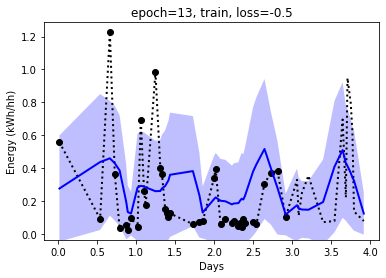

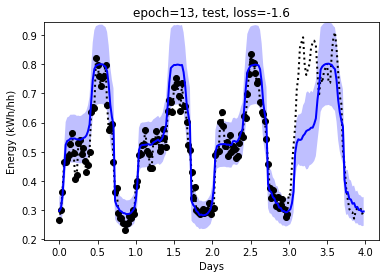

epoch: 13, loss: -1.121, loss_test:-1.643, kl=-0.62, grad_norm:  9.7


14, i=0, loss: -1.042, test: -1.669, grad_norm:  8.4, std:  0.13
14, i=100, loss: -1.096, test: -1.64, grad_norm:  11, std:  0.13
14, i=200, loss: -1.611, test: -1.599, grad_norm:  3.7, std:  0.12
14, i=300, loss: -0.9003, test: -1.416, grad_norm:  11, std:  0.13
14, i=400, loss: -1.421, test: -1.572, grad_norm:  3.4, std:  0.12
14, i=500, loss: -1.479, test: -1.496, grad_norm:  2.1, std:  0.12
14, i=600, loss: -1.169, test: -1.602, grad_norm:  2, std:  0.13
14, i=700, loss: -1.354, test: -1.619, grad_norm:  3.3, std:  0.13
14, i=800, loss: -0.6221, test: -1.712, grad_norm:  5, std:  0.13
14, i=900, loss: -1.294, test: -1.527, grad_norm:  2.5, std:  0.13
14, i=1000, loss: -1.147, test: -1.503, grad_norm:  5.7, std:  0.13


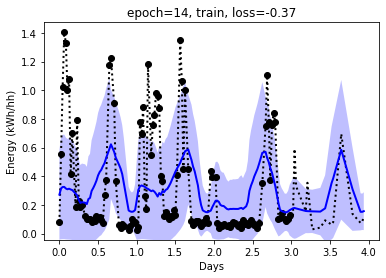

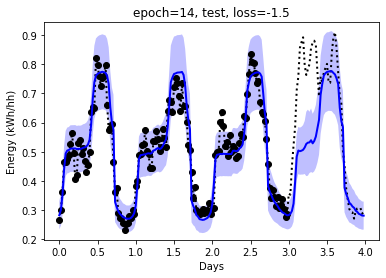

epoch: 14, loss: -1.304, loss_test:-1.504, kl=-0.58, grad_norm:  7.9


15, i=0, loss: -1.457, test: -1.541, grad_norm:  2.7, std:  0.12
15, i=100, loss: -1.425, test: -1.467, grad_norm:  5.1, std:  0.12
15, i=200, loss: -1.149, test: -1.552, grad_norm:  2.9, std:  0.12
15, i=300, loss: -1.091, test: -1.642, grad_norm:  6.4, std:  0.12
15, i=400, loss: -1.073, test: -1.678, grad_norm:  8.8, std:  0.12
15, i=500, loss: -1.319, test: -1.573, grad_norm:  8.4, std:  0.16
15, i=600, loss: -1.473, test: -1.632, grad_norm:  2.4, std:  0.13
15, i=700, loss: -1.454, test: -1.706, grad_norm:  2.2, std:  0.12
15, i=800, loss: -1.268, test: -1.72, grad_norm:  3.2, std:  0.12
15, i=900, loss: -1.367, test: -1.782, grad_norm:  2.3, std:  0.12
15, i=1000, loss: -1.338, test: -1.594, grad_norm:  6.8, std:  0.13


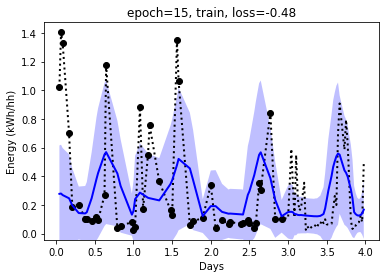

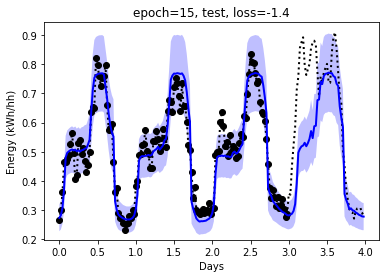

epoch: 15, loss: 0.01832, loss_test:-1.401, kl=-0.62, grad_norm:  25


16, i=0, loss: -1.277, test: -1.4, grad_norm:  2.2, std:  0.12
16, i=100, loss: -1.386, test: -1.49, grad_norm:  2.7, std:  0.13
16, i=200, loss: -0.6402, test: -1.449, grad_norm:  13, std:  0.19
16, i=300, loss: -1.407, test: -1.639, grad_norm:  1.8, std:  0.13
16, i=400, loss: -1.392, test: -1.553, grad_norm:  1.9, std:  0.12
16, i=500, loss: -1.384, test: -1.713, grad_norm:  2.6, std:  0.12
16, i=600, loss: -1.268, test: -1.764, grad_norm:  3.1, std:  0.12
16, i=700, loss: -1.144, test: -1.609, grad_norm:  3.7, std:  0.12
16, i=800, loss: -1.41, test: -1.799, grad_norm:  4.4, std:  0.12
16, i=900, loss: -1.354, test: -1.665, grad_norm:  3.5, std:  0.12
16, i=1000, loss: -1.401, test: -1.669, grad_norm:  3.1, std:  0.13


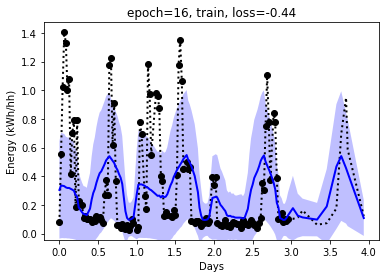

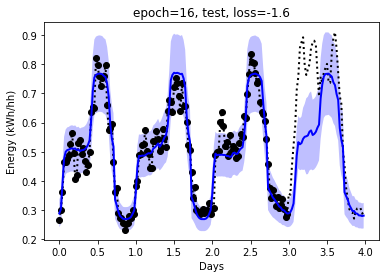

epoch: 16, loss: -1.251, loss_test:-1.627, kl=-0.55, grad_norm:  5.3


17, i=0, loss: -1.311, test: -1.616, grad_norm:  1.7, std:  0.13
17, i=100, loss: -1.368, test: -1.564, grad_norm:  3.2, std:  0.12
17, i=200, loss: -1.157, test: -1.712, grad_norm:  7, std:  0.13
17, i=300, loss: -1.272, test: -1.548, grad_norm:  5, std:  0.12
17, i=400, loss: -1.309, test: -1.513, grad_norm:  3.2, std:  0.12
17, i=500, loss: -1.205, test: -1.619, grad_norm:  4.8, std:  0.13
17, i=600, loss: -1.318, test: -1.391, grad_norm:  5.4, std:  0.12
17, i=700, loss: -1.524, test: -1.507, grad_norm:  2.5, std:  0.12
17, i=800, loss: -0.8503, test: -1.416, grad_norm:  3.5, std:  0.12
17, i=900, loss: -1.151, test: -1.543, grad_norm:  3.3, std:  0.12
17, i=1000, loss: -0.8768, test: -1.626, grad_norm:  6.5, std:  0.12


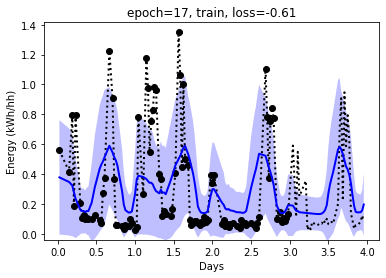

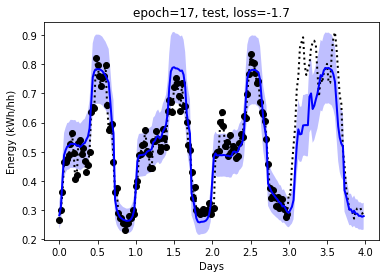

epoch: 17, loss: -1.356, loss_test:-1.698, kl=-0.67, grad_norm:  7.8


18, i=0, loss: -1.52, test: -1.708, grad_norm:  3.1, std:  0.12
18, i=100, loss: -1.504, test: -1.717, grad_norm:  4.8, std:  0.11
18, i=200, loss: -1.527, test: -1.539, grad_norm:  2, std:  0.11
18, i=300, loss: -1.335, test: -1.675, grad_norm:  7.1, std:  0.11
18, i=400, loss: -1.318, test: -1.461, grad_norm:  5.5, std:  0.12
18, i=500, loss: -1.537, test: -1.749, grad_norm:  2.2, std:  0.11
18, i=600, loss: -1.479, test: -1.42, grad_norm:  2.1, std:  0.12
18, i=700, loss: -1.447, test: -1.59, grad_norm:  3.9, std:  0.12
18, i=800, loss: -1.357, test: -1.653, grad_norm:  4, std:  0.12
18, i=900, loss: -1.323, test: -1.636, grad_norm:  2.9, std:  0.12
18, i=1000, loss: -1.468, test: -1.472, grad_norm:  2.5, std:  0.12


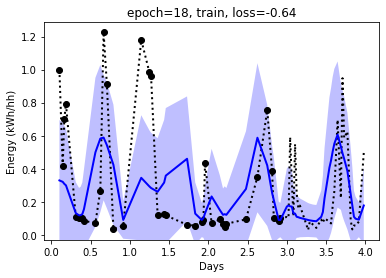

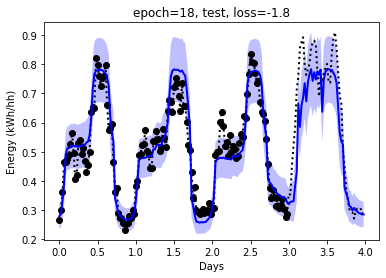

epoch: 18, loss: -1.323, loss_test:-1.809, kl=-0.37, grad_norm:  5.8


19, i=0, loss: -1.312, test: -1.835, grad_norm:  2.7, std:  0.11
19, i=100, loss: -1.604, test: -1.583, grad_norm:  2.3, std:  0.12
19, i=200, loss: -1.321, test: -1.388, grad_norm:  6.2, std:  0.12
19, i=300, loss: -1.486, test: -1.659, grad_norm:  5.3, std:  0.12
19, i=400, loss: -1.421, test: -1.772, grad_norm:  1.8, std:  0.11
19, i=500, loss: -1.55, test: -1.739, grad_norm:  2.1, std:  0.12
19, i=600, loss: -1.504, test: -1.7, grad_norm:  2.1, std:  0.12
19, i=700, loss: -1.471, test: -1.68, grad_norm:  3.9, std:  0.12
19, i=800, loss: -1.013, test: -1.84, grad_norm:  9.8, std:  0.11
19, i=900, loss: -1.538, test: -1.681, grad_norm:  2.2, std:  0.11
19, i=1000, loss: -1.405, test: -1.428, grad_norm:  3.6, std:  0.11


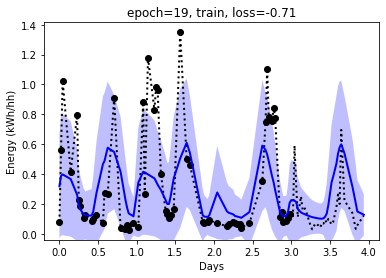

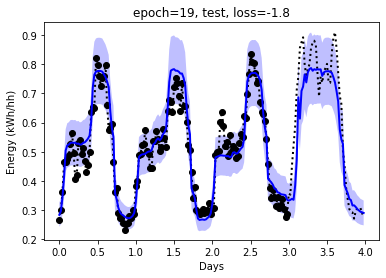

epoch: 19, loss: -0.9699, loss_test:-1.823, kl=-0.59, grad_norm:  8


In [41]:
epochs = 20
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

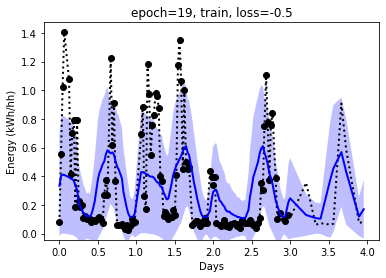

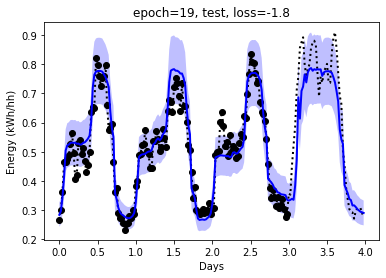

In [42]:
test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
model.eval()
test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')

## History

In [45]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['n']/(df_hist['epoch']+1)
df_hist.head(3)

,epoch,grad_norm,i,kl,loss,n,test_loss,y_std
0,0,140508.984160,0,57.015362,423.490082,0.0,16.190365,1.439006e-01
1,0,170.863026,100,8.726626,9.211174,100.0,2.989760,5.272529e+01
2,0,8.196656,200,2.959328,3.038778,200.0,1.786752,5.895241e+08


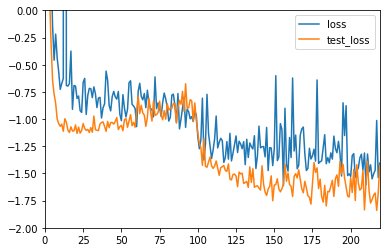

In [59]:
(df_hist[['loss', 'test_loss']]).plot(ylim=[-2,0])

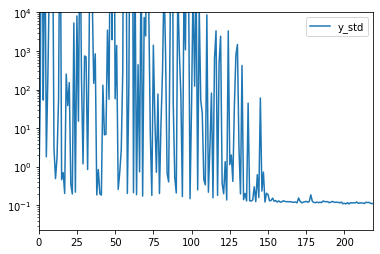

In [63]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)